In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')
from Cell2D import Cell2D, Cell2DViewer


In [27]:
_N_ = 0 # NORTH
_S_ = 1 # SOUTH
_E_ = 2 # EAST
_W_ = 3 # WEST

class Intersection(Cell2D):

    ## Initialization of system parameters
    #  @param numlane   number of lanes approaching from each direction [N,S,E,W]
    #  @param leftlane  number of left turn lanes approaching from each direction [N,S,E,W] 
    #  @param prob      probabilities of a vehicle spawning from each direction [N,S,E,W] per simulation time period
    def __init__(self, numlane=[1,1,1,1], leftlane=[0,0,0,0], prob=[.25,.25,.25,.25]):
        self.numlane = numlane
        self.prob = prob

        self.light=True
        self.light_N = 0

        # The distance from the intersection to the system boundary, where cars are spawned
        self.whiteSpaceConst = 15
        
        # Dimensions m and n of matrix representing system grid map
        self.m = (numlane[_N_] + numlane[_S_] + self.whiteSpaceConst + leftlane[_N_] + leftlane[_S_]) * 2 + 1
        self.n = (numlane[_E_] + numlane[_W_] + self.whiteSpaceConst + leftlane[_E_] + leftlane[_W_]) * 2 + 1
        
        # Sets of spawn locations for vehicles 
        self.spawnLocN = []
        self.spawnLocS = []
        self.spawnLocE = []
        self.spawnLocW = []
        self.spawnLocNL = []
        self.spawnLocSL = []
        self.spawnLocEL = []
        self.spawnLocWL = []
        self.stopLocN = []  
        self.stopLocS = []
        self.stopLocE = []
        self.stopLocW = []
        self.stopLocNL = []
        self.stopLocSL = []
        self.stopLocEL = []
        self.stopLocWL = []
        
        # The 2D grid space for simulation
        self.array = np.zeros((self.n, self.m), np.float)
    
        # Populate lists of vehicle spawning locations in grid 
        for i in range(self.whiteSpaceConst):
            laneConst = 0
            for j in range(numlane[_N_]):
                if i ==0:
                    self.spawnLocN.append((0,self.whiteSpaceConst+laneConst+1))
                    self.stopLocN.append((self.whiteSpaceConst -1 ,self.whiteSpaceConst+laneConst+1))

                if j is 0:
                    self.array[i, self.whiteSpaceConst + laneConst] = 1
                    self.array[self.n-i -1, self.whiteSpaceConst + laneConst] = 1
                            
                else:
                    self.array[i, self.whiteSpaceConst + laneConst] = .2
                    self.array[self.n-i-1, self.whiteSpaceConst + laneConst] = .2
                laneConst = laneConst + 2

            for j in range(leftlane[_N_]):
                if i ==0:
                    self.spawnLocNL.append((0,self.whiteSpaceConst+laneConst+1))
                    self.spawnLocNL.append((self.n-1,self.whiteSpaceConst+laneConst+1))
                self.array[i, self.whiteSpaceConst + laneConst] = .5

                if j == 0:
                    self.array[self.n-i-1, self.whiteSpaceConst + laneConst ] = 1
                else:
                    self.array[self.n-i-1, self.whiteSpaceConst + laneConst ] = .5
                self.array[self.n-i-1, self.whiteSpaceConst + laneConst + 2] = .5
                laneConst = laneConst + 2

                
            for j in range(numlane[_S_]):
                if i ==0:
                    self.spawnLocS.append((self.n - 1, self.whiteSpaceConst+laneConst+1))
                    self.stopLocS.append((self.n - self.whiteSpaceConst, self.whiteSpaceConst+laneConst+1))

                if j is 0:
                    if(leftlane[_N_]):
                        self.array[i, self.whiteSpaceConst + laneConst] = 1
                    else:
                        self.array[i, self.whiteSpaceConst + laneConst] = 1
                        self.array[self.n-i-1, self.whiteSpaceConst + laneConst] = 1

                else:
                    self.array[i, self.whiteSpaceConst + laneConst] = .2
                    self.array[self.n-i-1, self.whiteSpaceConst + laneConst] = .2
                laneConst = laneConst + 2
            
            self.array[i, self.whiteSpaceConst + laneConst] = 1
            self.array[self.n-i-1, self.whiteSpaceConst + laneConst] = 1
            laneConst = 0

            for j in range(numlane[_E_]):
                if i ==0:
                    self.spawnLocE.append((self.whiteSpaceConst+laneConst+1, self.m - 1))
                    self.stopLocE.append((self.whiteSpaceConst+laneConst+1, self.m - self.whiteSpaceConst + 1))

                if j is 0:
                    self.array[self.whiteSpaceConst + laneConst, i] = 1
                    self.array[ self.whiteSpaceConst + laneConst, self.m- i -1] = 1

                else:
                    self.array[self.whiteSpaceConst + laneConst, i ] = .2
                    self.array[ self.whiteSpaceConst + laneConst, self.m-i-1] = .2
                laneConst = laneConst + 2
                
            for j in range(leftlane[_W_]):
                if i ==0:
                    self.spawnLocE.append((self.whiteSpaceConst+laneConst+1, self.m - 1))
                    self.spawnLocE.append((self.whiteSpaceConst+laneConst+1, 0))
                self.array[self.whiteSpaceConst + laneConst + 2, i] = .5

                if j == 0:
                    self.array[self.whiteSpaceConst + laneConst, i] = 1
                else:
                    self.array[ self.whiteSpaceConst + laneConst, self.m-i-1] = .5

                self.array[ self.whiteSpaceConst + laneConst, m-i-1] = .5
                self.array[ self.whiteSpaceConst + laneConst + 2, i] = .5
                laneConst = laneConst + 2
            
            for j in range(numlane[_W_]):
                if i ==0:
                    self.spawnLocW.append((self.whiteSpaceConst+laneConst+1, 0))
                    self.stopLocW.append((self.whiteSpaceConst+laneConst+1, self.whiteSpaceConst-1))
                    
                if j is 0:
                    if(leftlane[_W_]):
                        self.array[self.whiteSpaceConst + laneConst, i] = 0.5
                        self.array[ self.whiteSpaceConst + laneConst, self.m- i -1] = 1

                    else:
                        self.array[self.whiteSpaceConst + laneConst, i] = 1
                        self.array[self.whiteSpaceConst + laneConst, self.m- i -1] = 1
                    
                else:
                    self.array[self.whiteSpaceConst + laneConst, i] = .2
                    self.array[self.whiteSpaceConst + laneConst, self.m- i -1] = .2
                laneConst = laneConst + 2
            
            self.array[self.whiteSpaceConst + laneConst, i] = 1
            self.array[self.whiteSpaceConst + laneConst, self.m- i -1] = 1
        
        print(self.array)

    ## Steps through time, simulates motion of vehicle for period 
    def step(self):
        self.light_N+=1
        
        if self.light_N == 80:
            self.light_N=0
    
        if self.light_N < 20:
            L=1
        if self.light_N >=20 and self.light_N < 40:
            L=2
        if self.light_N >=40 and self.light_N < 60:
            L=3
        if self.light_N >=60 and self.light_N < 80:
            L=4
            
        # For the West->East Lane
        for i in reversed(range(self.m)):
            for item in self.stopLocW:
                
                if i == self.m - 1:
                    self.array[item[0], i] = 0
                elif(((self.array[item[0], i] == 0.7) and self.array[item[0], i+1] != 0.7)) :
                    if (L==1 or (L!=1 and i != self.whiteSpaceConst-1)):
                        self.array[item[0], i] = 0
                        if i != self.m - 1:
                            self.array[item[0], i+1] = 0.7     
        
        for i in range(self.m):
            for item in self.stopLocE:
                if self.array[item[0], i] == 0.7 and self.array[item[0], i-1] != 0.7 :
                    if (L==1 or (L!=1 and i != self.m- self.whiteSpaceConst)):
                        self.array[item[0], i] = 0
                        if i !=0:
                            self.array[item[0], i-1] = 0.7
        
        for i in range(self.n):
            for item in self.stopLocS:
                if self.array[i,item[1]] == 0.8 and self.array[i-1,item[1]] != 0.8:
                    if (L==3 or (L!=3 and i != self.n-self.whiteSpaceConst)):
                        self.array[i,item[1]] = 0
                        if i != 0:
                            self.array[i-1,item[1]] = 0.8
        
        for i in reversed(range(self.n)):
            for item in self.stopLocN:
                if i==self.n - 1:  
                    self.array[i,item[1]] = 0                
                elif((self.array[i,item[1]] == 0.8) and (self.array[i+1,item[1]] != 0.8)):
                    if (L==3 or (L!=3 and i !=self.whiteSpaceConst-1)):
                        self.array[i,item[1]] = 0
                        if i != self.n - 1:
                            self.array[i+1,item[1]] = 0.8
        
        # Spawn new vehicles
        self.populateLane(self.prob[0], _N_)
        self.populateLane(self.prob[1], _S_)
        self.populateLane(self.prob[2], _E_)
        self.populateLane(self.prob[3], _W_)
        '''for item in self.spawnLocNL:
            self.populateLane(item[0], item[1],.10, "NL")
        for item in self.spawnLocWL:
            self.populateLane(item[0], item[1],.10, "WL")
        for item in self.spawnLocEL:
            self.populateLane(item[0], item[1],.10, "EL")
        for item in self.spawnLocSL:
            self.populateLane(item[0], item[1],.10, "SL")'''
            
    ## Conditionally fills spawn locations from 'direction' with vehicles based on 'probability'
    #  @param probability Chance of vehicle spawn for each spawn
    #  @param direction   Direction of spawn origin  
    def populateLane(self, probability=0, direction=_N_):
        if direction == _N_:
            num = np.random.choice(len(self.spawnLocN), 1)[0]
            if (probability > np.random.random()):
                self.array[self.spawnLocN[num][0], self.spawnLocN[num][1]] = 0.8

        if direction == _S_:
            num = np.random.choice(len(self.spawnLocS), 1)[0]
            if (probability > np.random.random()):
                self.array[self.spawnLocS[num][0], self.spawnLocS[num][1]] = 0.8

        if direction == _E_:
            num = np.random.choice(len(self.spawnLocE), 1)[0]
            if (probability > np.random.random()):
                self.array[self.spawnLocE[num][0], self.spawnLocE[num][1]] = 0.7

        if direction == _W_:
            num = np.random.choice(len(self.spawnLocW), 1)[0]
            if (probability > np.random.random()):
                self.array[self.spawnLocW[num][0], self.spawnLocW[num][1]] = 0.7

        if direction == "NL":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7

        if direction == "SL":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7

        if direction == "EL":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7

        if direction == "WL":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7
                

In [28]:
class IntersectionView(Cell2DViewer):
    cmap = plt.get_cmap('spectral_r')
    
intersection = Intersection(numlane=[2,2,4,4], prob=[0.4,0.5,0.6,0.2])
viewer = IntersectionView(intersection)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


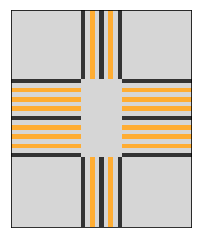

In [29]:
anim = viewer.animate(frames=300, interval=300)

In [358]:
anim